# TP : BAGGING, BOOSTING, RANDOM FORESTS

### Thai-An THAN TRONG

# SETTINGS

In [1]:
import math 
import numpy as np
from sklearn import linear_model
from sklearn.utils import shuffle as sh
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import sklearn.datasets
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

from os import mkdir
from os import path 

import pandas as pd
import urllib
import zipfile

import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec

In [2]:
# Show the graphs here
%pylab inline

# Configuration
pylab.rcParams['figure.figsize'] = (14,8) # figures sizes
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Chose ggplot instead of seaborn

lw = 2.5 # linewidth in all graphics
sc = 60 # Scatter size
alp=0.7

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Colors
c_tree = "deepskyblue"
c_bagging = "mediumvioletred"
c_bagging_bt = "limegreen"

c_rf = "palevioletred"
c_svm = "mediumseagreen"
c_dt = "limegreen"

c_train = "teal"
c_test = "darkslateblue"

c_train_adaboost = "turquoise"
c_test_adaboost = "lightsteelblue"

# BAGGING

# Question 1

In [4]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

In [5]:
def plot_tree_bag(X=X, y=y, X_test=X_test, L=10, tree_max_depth=1, bagging_max_depth=10):
    # define the regressor by bagging stumps
    tree = DecisionTreeRegressor(max_depth=tree_max_depth)
    tree.fit(X, y)

    bagging = BaggingRegressor(base_estimator=tree, n_estimators=L, 
                               max_samples=bagging_max_depth)
    
    bagging.fit(X, y)

    # Predict
    y_tree = tree.predict(X_test)
    y_bagging = bagging.predict(X_test)
    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.plot(X, y, 'o', c="k", label="data")
    # add plots for Bagging/Tree
    plt.plot(X_test, y_tree, marker='.', color=c_tree, alpha=alp, label="Tree (tree_max_depth=%d)"%tree_max_depth, linewidth=lw)
    plt.plot(X_test, y_bagging, marker='.', color=c_bagging_bt, alpha=alp, label="Bagging (tree_max_depth=%d)"%tree_max_depth, linewidth=lw)

    plt.title("Decision Tree Regression")
    plt.legend(loc=1, numpoints=1)
    plt.show()

## Etude de max_samples

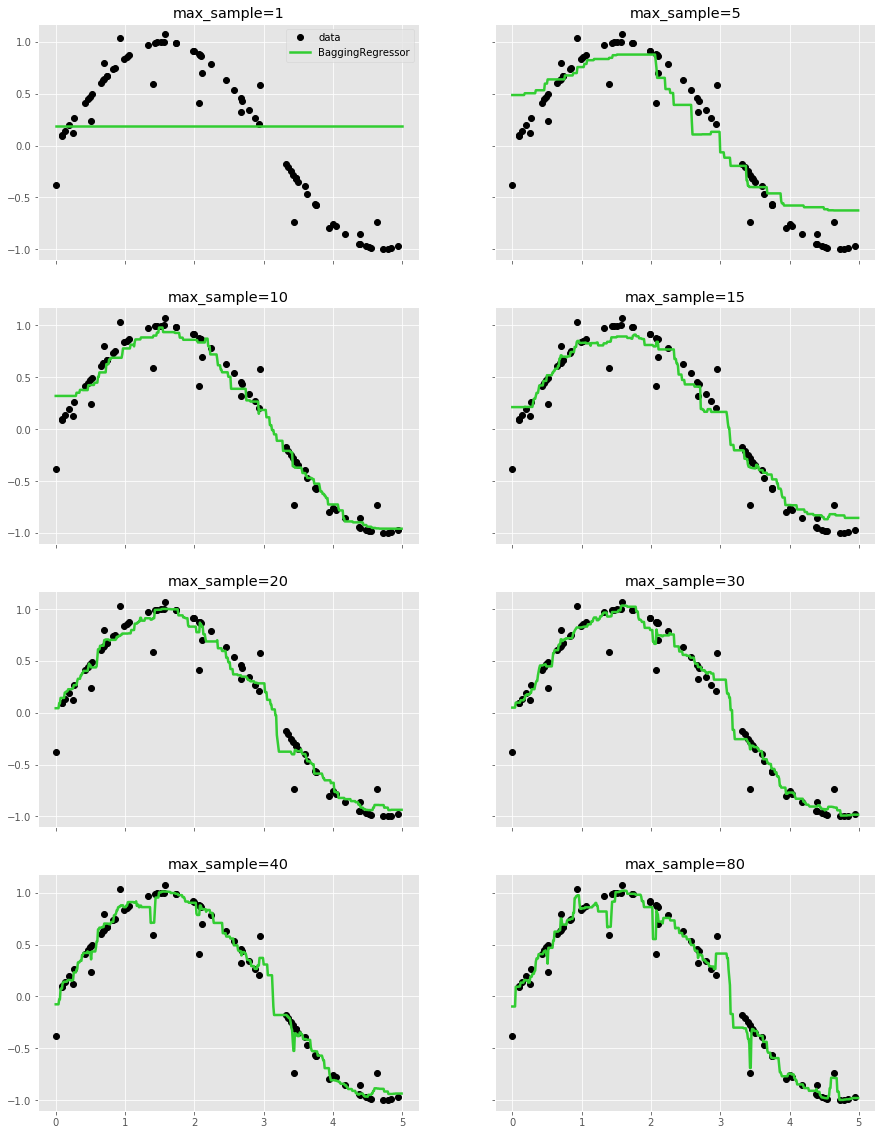

In [6]:
sample_depths = [1, 5, 10, 15, 20, 30, 40, len(X)]

# for plots
fig, axs = plt.subplots(int(len(sample_depths)/2), 2, facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(15,20))

index = 0
for i in range(int(len(sample_depths)/2)): # test all max_sample
    for j in range(2):
        bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), 
                                   n_estimators = 10, max_samples=sample_depths[index])
        bagging.fit(X, y)

        # predictions
        y_pred = bagging.predict(X_test)

        # plot everything
        axs[i][j].plot(X, y, 'o', c="k", label="data")
        axs[i][j].plot(X_test, y_pred, c=c_bagging_bt, linewidth=lw, label="BaggingRegressor")
        axs[i][j].set_title("max_sample=%d"%(sample_depths[index]))
        index += 1
        
axs[0][0].legend()   
plt.show()

## Cas max_depth = 1

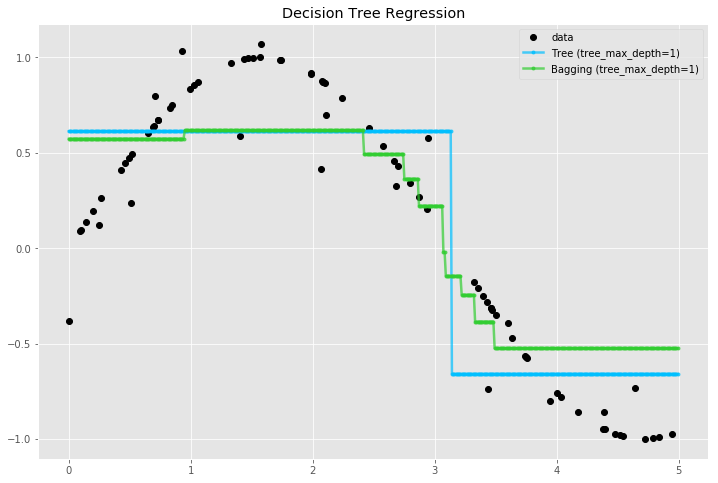

In [7]:
# tree_max_depth = 1
plot_tree_bag()

Pour une profondeur d'arbre égale à 1, les modèles d'arbre de décision et de bagging ne prédisent pas suffisament les données. La forme des courbes de résultat obtenues ne correpond pas au jeu de données sur lequel on a testé. Les modèles sous-apprennent (underfitting).

Nous allons tester avec une profondeur d'arbre plus élevée.

## Cas max_depth = 10

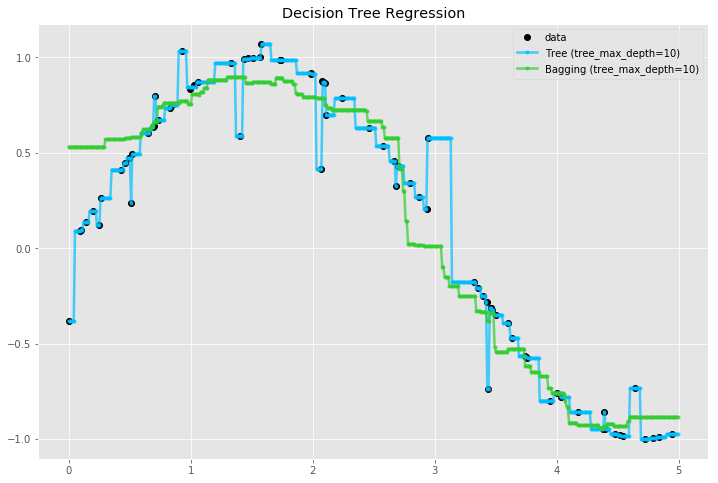

In [8]:
# tree_max_depth = 10
plot_tree_bag(L=10, tree_max_depth=10)

Contrairement au cas précédent où les courbes ne s'ajustaient pas aux données, les coubres obtenues avec une profondeur égale à 10 restituent très bien le comportement des données. On peut en effet voir l'allure sinusoidale des courbes. En particulier, les modèles prennent en compte les points bruités. On peut se demander si les modèles non pas sur-appris sur nos données d'apprentissage (overfitting).

Par la suite, il faudra étudier comment ajuster les hyperparamètres tels que le nombre d'estimateurs L ou la profondeur maximale de l'arbre pour obtenir des modèles estimant correctement nos données, et limitant les cas critiques d'underfitting et d'overfitting.

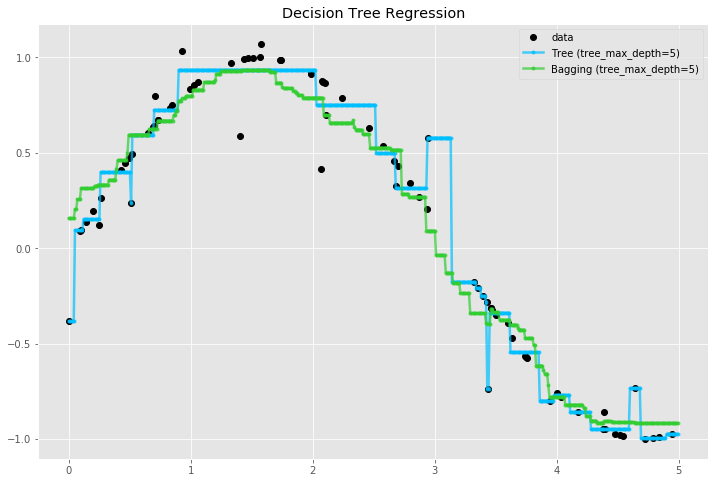

In [9]:
# tree_max_depth = 5
plot_tree_bag(L=10, tree_max_depth=5)

# Question 2

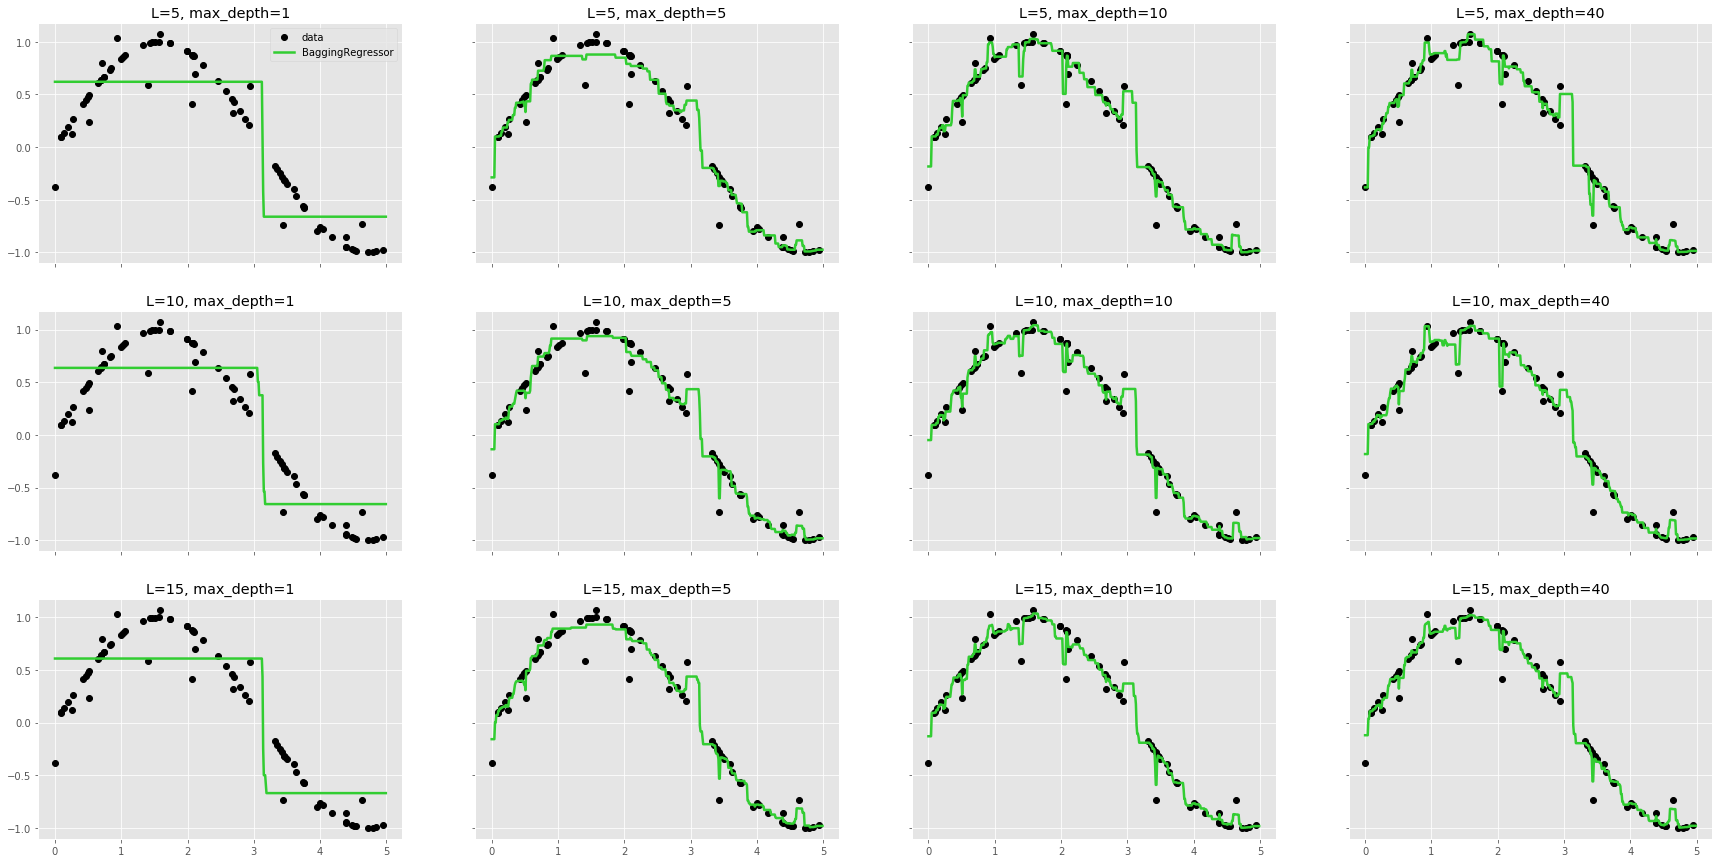

In [10]:
# The result we ideally expect to have
y_test = np.sin(X_test).ravel()

Ls = [5, 10, 15]
depths = [1, 5, 10, 40]

# Create a double loop for L and max_depth
scores = np.zeros((len(Ls), len(depths))) # create a matrix to store the scores. Rows = L, Columns = max_depth
baggings = [] # store the models

# for plots
fig, axs = plt.subplots(len(Ls), len(depths), facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(30,15))

for i, l in enumerate(Ls, 0): # test all Ls
    #print("Setting L=%d" %l)
    for j, d in enumerate(depths, 0): # test all depths
        #print("    | Setting max_depth=%d" %d)
        bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=d), 
                                   n_estimators = l)
        bagging.fit(X, y)
        scores[i, j] = bagging.score(X_test, y_test)
        baggings.append(bagging)
        
        # predictions
        y_pred = bagging.predict(X_test)
        
        # plot everything
        axs[i][j].plot(X, y, 'o', c="k", label="data")
        axs[i][j].plot(X_test, y_pred, c=c_bagging_bt, linewidth=lw, label="BaggingRegressor")
        axs[i][j].set_title("L=%d, max_depth=%d"%(l, d))
        
axs[0][0].legend()   
plt.show()

Les graphiques ci-dessus permettent d'observer l'impact des paramètres L et max_depth sur les modèles. Pour une ligne fixée, on fait ainsi varier la profondeur des arbres, tandis que pour une colonne fixée, on fait varier L.

Au fur et à mesure que l'on augmente L (en regardant les figures le long d'une colonne donnée et de haut en bas), l'allure de la courbe semble globalement conservée, il n'y a pas de modfication flagrante ; on observe néanmoins que pour un L relativement élevé le modèle atteint des points bruités (la courbe s'éloigne de temps à autre de l'allure sinusoïdale) : le modèle a tendance à sur-apprendre.

Plus on fait varier la profondeur, plus le modèle est précis. , l'allure sinusoidale de la courbe apparaît davantage. En faisant varier la profondeur de 5 à 15, on observe en effet l'évolution de la courbe et son ajustement aux données. 
- Pour une profondeur faible, égale à 1, le modèle n'est pas proche des données : le biais est élevé.
- Pour une profondeur supérieure à 10, le modèle sur-apprend : la variance est élevée.
La profondeur de l'arbre permet de modifier la variance.

# Question 3

Nous avons pu voir dans la question précédente que des valeurs élevées de L et de la profondeur d'arbre peuvent faire varier de manière significative les prédictions sur un jeu de données test. 

En régression, le risque d'un estimateur se décompose suivant le biais, la variance et le bruit.

La variance exprime la variabilité des prédictions d'un estimateur sur différentes instances du problème. Dans le cas des arbres de décision, la profondeur de l'arbre détermine la variance.

Pour une faible valeur de profondeur d'arbre (par exemple max_depth=1), le biais est élevé : les abres ne peuvent pleinement approximer les données, mais la variance entre les différents essais est faible. Lorsque la profondeur augmente, le biais diminue : les courbes obtenues se rapprochent davantage du jeu de données test. Cependant, les modèmes d'arbres sont désormais sensibles données, en particulier si celles-ci sont bruitées : la variance est large.

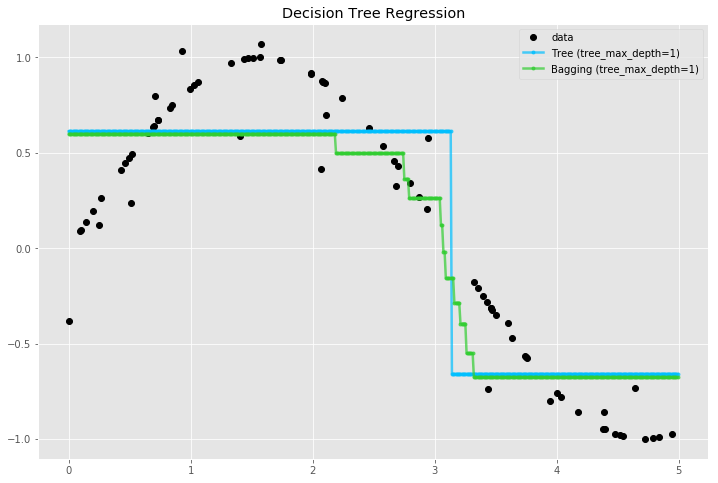

In [11]:
plot_tree_bag(L=10, tree_max_depth=1)

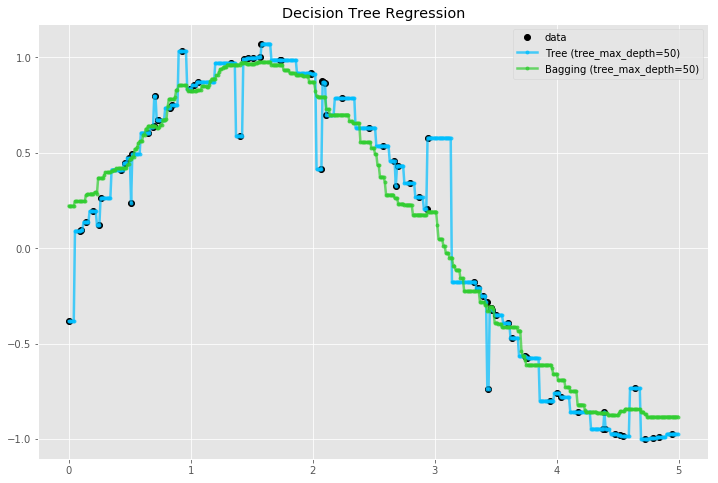

In [12]:
plot_tree_bag(L=20, tree_max_depth=50)

Le bagging permet de d'agréger les arbres, et donc de réduire la sensibilité aux variations. La variance est ainsi plus faible qu'avec l'arbre de décision seul. 

# Question 4

In [13]:
# Start with the random dataset again
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()

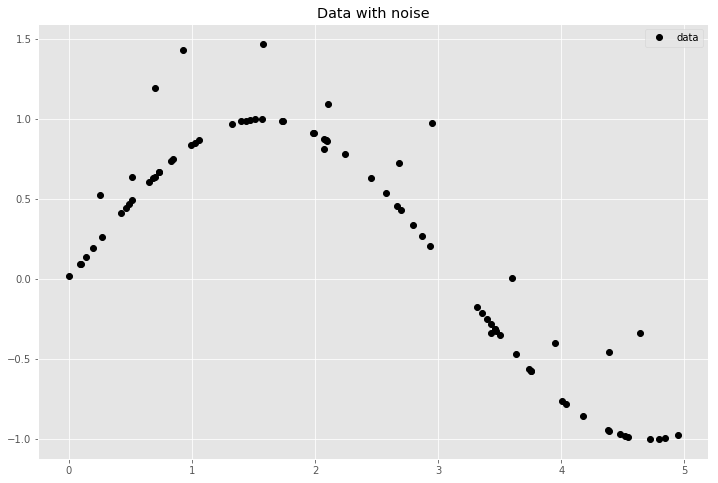

In [14]:
def generate_noise(X, s=0.5):
    y_noise = np.sin(X).ravel()
    y_noise[::5] += 1 * (s - rng.rand(16))
    return y_noise

# Plot the results
y_noise = generate_noise(X, s=0.9)
plt.figure(figsize=(12, 8))
plt.plot(X, y_noise, 'o', c="k", label="data")

plt.title("Data with noise")
plt.legend(loc=1, numpoints=1)
plt.show()

In [15]:
# Create a noise list with different noise values
noise_list = np.arange(0.5, 1.01, 0.1)
print(noise_list)

[ 0.5  0.6  0.7  0.8  0.9  1. ]


In [16]:
# Generate y with these noises
y_list = [generate_noise(X, s=n) for n in noise_list]

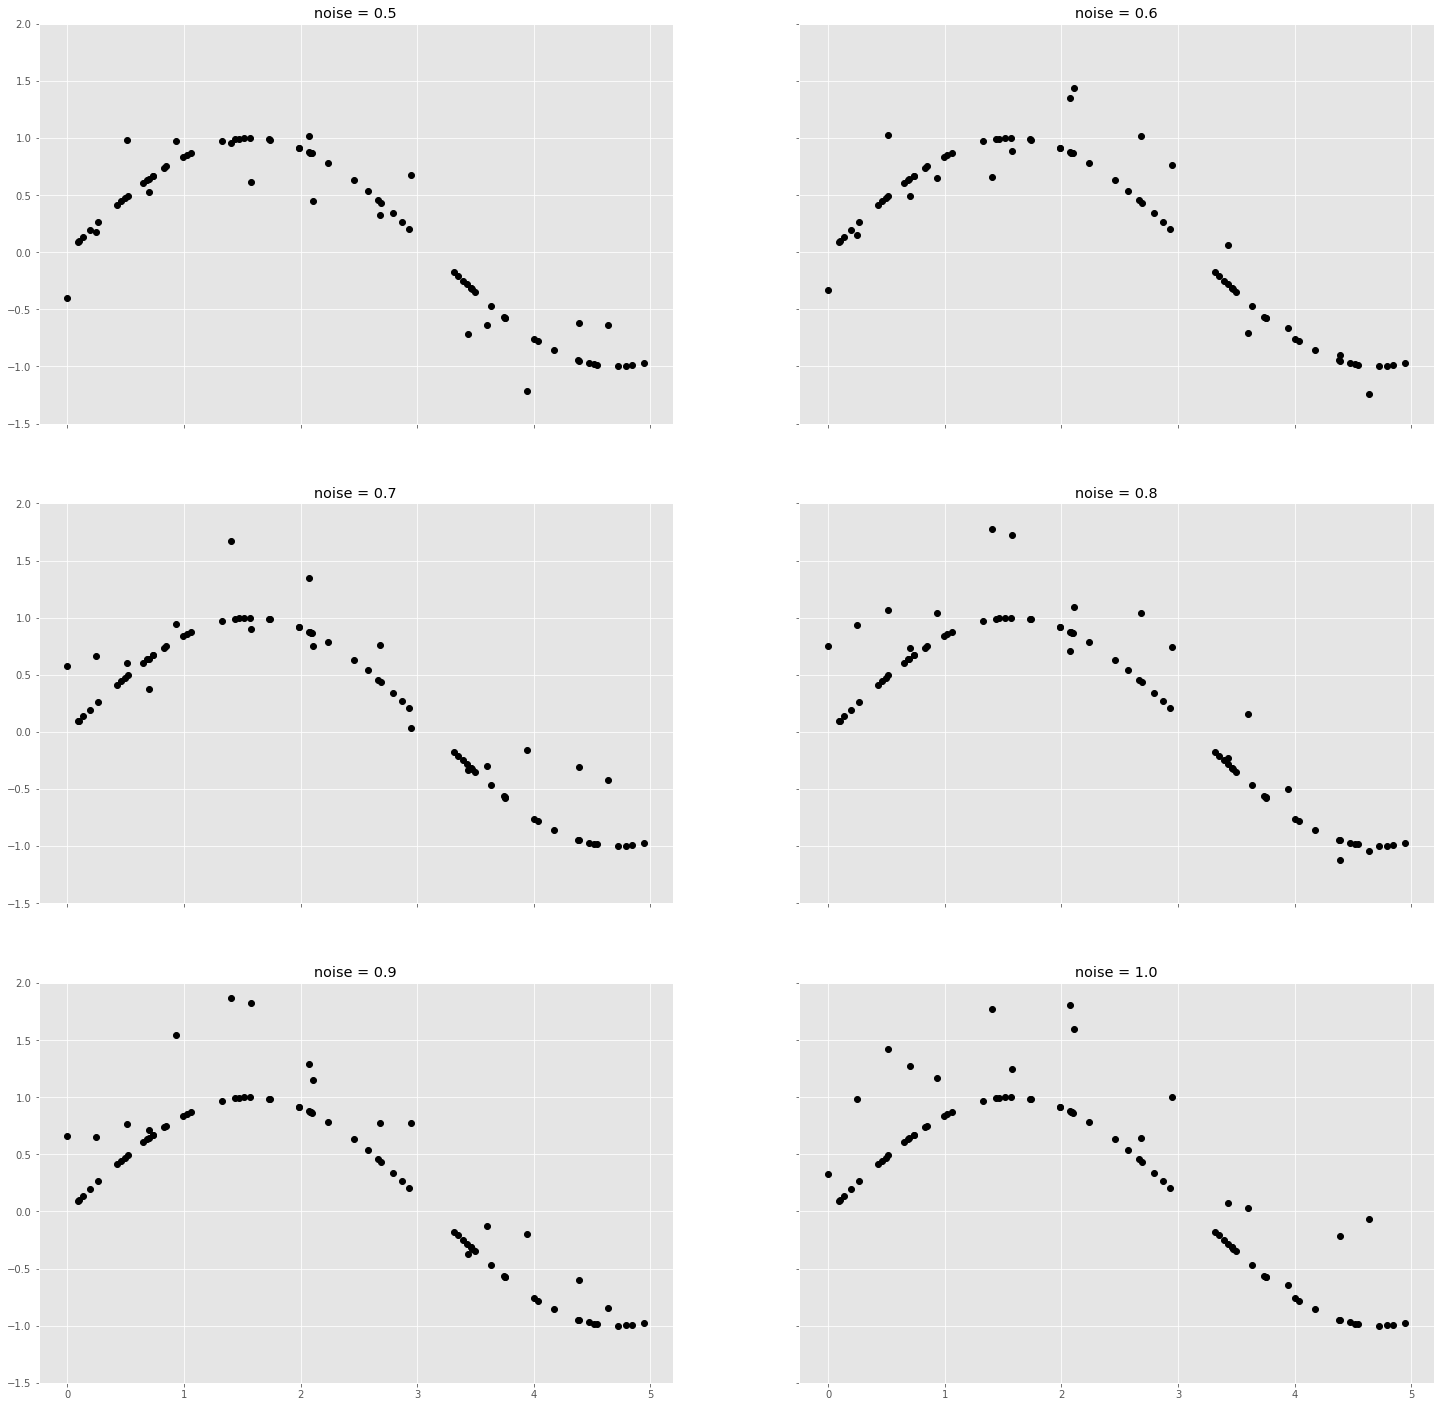

In [17]:
# Generate multiple data with noise
fig, axs = plt.subplots(3, 2, facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(25,25))

noise = 0
for i in range(3):
    j= 0 
    for p in y_list[2*i:2*(i+1)]:
        axs[i][j].plot(X, p, 'o', c="k")
        axs[i][j].set_title("noise = %.1f" %noise_list[noise])
        axs[i][j].set_ylim(-1.5, 2.0)
        j += 1
        
        noise+=1

plt.show()

Ces nouvelles données vont servir par la suite à tester nos arbres de décision et à mettre en évidence le sur-apprentissage.

In [18]:
# Create a fitted tree for each y_noise
def fit_noise(X, y_list, max_depth=10):

    tree_noise = []

    for y in y_list:
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X, y)
        tree_noise.append(tree)

    return tree_noise

In [19]:
tree_noise = fit_noise(X, y_list)

In [20]:
def plot_noise(X, X_test, tree_noise, y_list):
    # 2 columns
    if (len(tree_noise) % 2 == 0):
        print("Number of plots : even")
        n_rows = int(len(tree_noise) / 2)
    else: 
        print("Number of plots : odd")
        n_rows = int(len(tree_noise) / 2) + 1
    print("Number of rows :", n_rows)
    
    fig, axs = plt.subplots(n_rows, 2, facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(15, 20))
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    
    noise = 0
    for i in range(n_rows):
        print("Line ", i)
        j = 0
        for tree in tree_noise[2*i:2*(i+1)]:
            axs[i][j].plot(X, y_list[noise], 'o', c="k")
            axs[i][j].plot(X_test, tree.predict(X_test), alpha=alp, color=c_tree, linewidth=lw)
            title = 'noise = %.1f (max_depth=%d)' %(noise_list[noise], tree.max_depth)
            axs[i][j].set_title(title)
            axs[i][j].set_ylim(-1.5, 2.0)
        
            j += 1
            noise += 1


    plt.show()

Number of plots : even
Number of rows : 3
Line  0
Line  1
Line  2


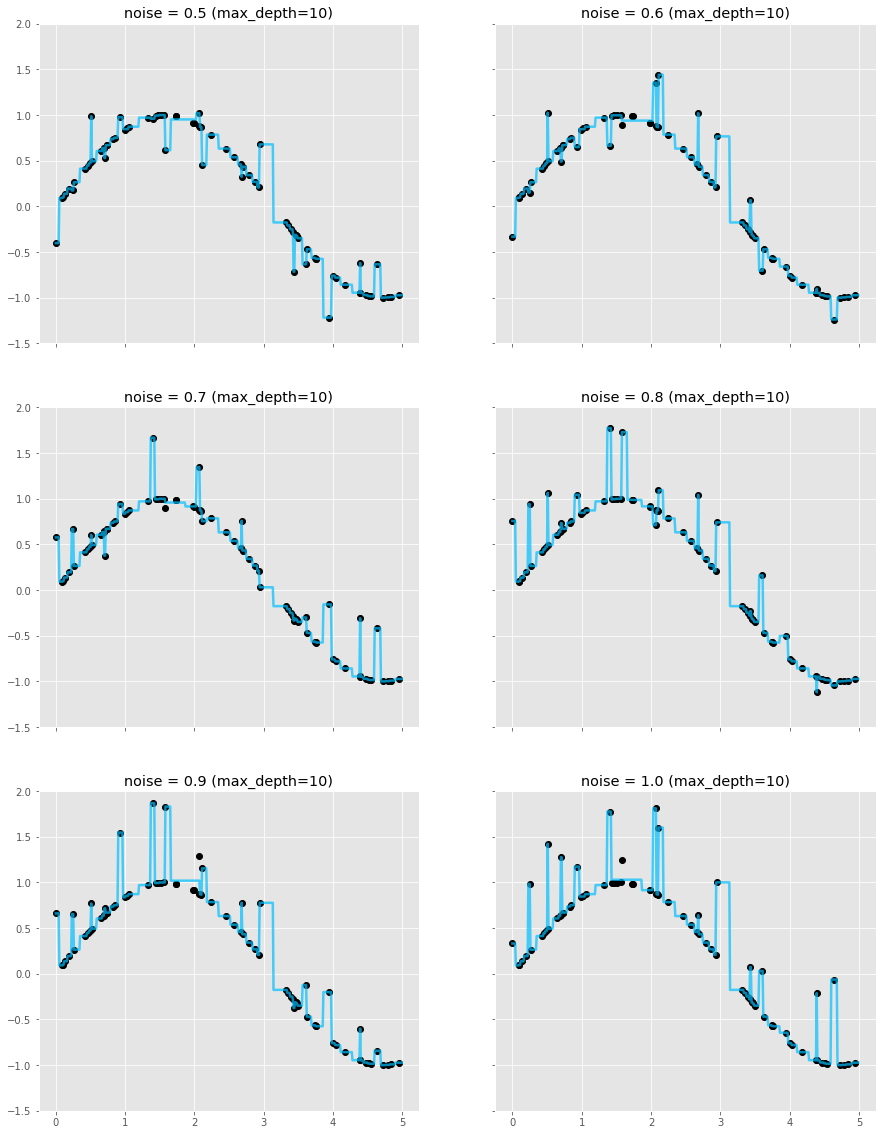

In [21]:
plot_noise(X, X_test, tree_noise, y_list)

Pour une profondeur d'arbre égale à 10, on remarque effectivement que pour différents jeux de données bruités, sur lequel on entraine un arbre de décision, le modèle obtenu sur-apprend et suit le motif des données de départ. 

# Question 5

On se place dans le cas où L=10 et max_depth=10

In [22]:
L = 10
max_depth = 10

In [23]:
def plot_noise_comparison(X, X_test, y_list, noise_list, tree_max_depth=10, bagging_max_depth=10):
    # 2 columns
    if (len(noise_list) % 2 == 0):
        print("Number of plots : even")
        n_rows = int(len(noise_list) / 2)
    else: 
        print("Number of plots : odd")
        n_rows = int(len(noise_list) / 2) + 1
    print("Number of rows :", n_rows)
    
    fig, axs = plt.subplots(n_rows, 2, facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(15, 20))
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    
    k = 0
    for i in range(n_rows):
        print("Line ", i)
        j = 0
        for noise in y_list[2*i:2*(i+1)]:
            
            # define the regressor by bagging stumps
            tree = DecisionTreeRegressor(max_depth=tree_max_depth)
            tree.fit(X, noise)

            bagging = BaggingRegressor(base_estimator=tree, n_estimators=L, 
                                       max_samples=bagging_max_depth, bootstrap=False)
            bagging.fit(X, noise)

            bagging_bt = BaggingRegressor(base_estimator=tree, n_estimators=L, 
                                       max_samples=bagging_max_depth, bootstrap=True)
            bagging_bt.fit(X, noise)
    
            axs[i][j].plot(X, noise, 'o', c="k", label="data")
            axs[i][j].plot(X_test, tree.predict(X_test), alpha=alp, color=c_tree, linewidth=lw, label="DecisionTreeRegressor")
            axs[i][j].plot(X_test, bagging.predict(X_test), alpha=alp, color=c_bagging, linewidth=lw, label="BaggingRegressor bootstrap=False")
            axs[i][j].plot(X_test, bagging_bt.predict(X_test), alpha=alp, color=c_bagging_bt, linewidth=lw, label="BaggingRegressor bootstrap=True")
            title = 'noise = ' + str(noise_list[k])
            axs[i][j].set_title(title)
            axs[i][j].set_ylim(-1.5, 2.0)
        
            j += 1
            k += 1

    axs[0][0].legend()
    plt.show()

Number of plots : even
Number of rows : 3
Line  0
Line  1
Line  2


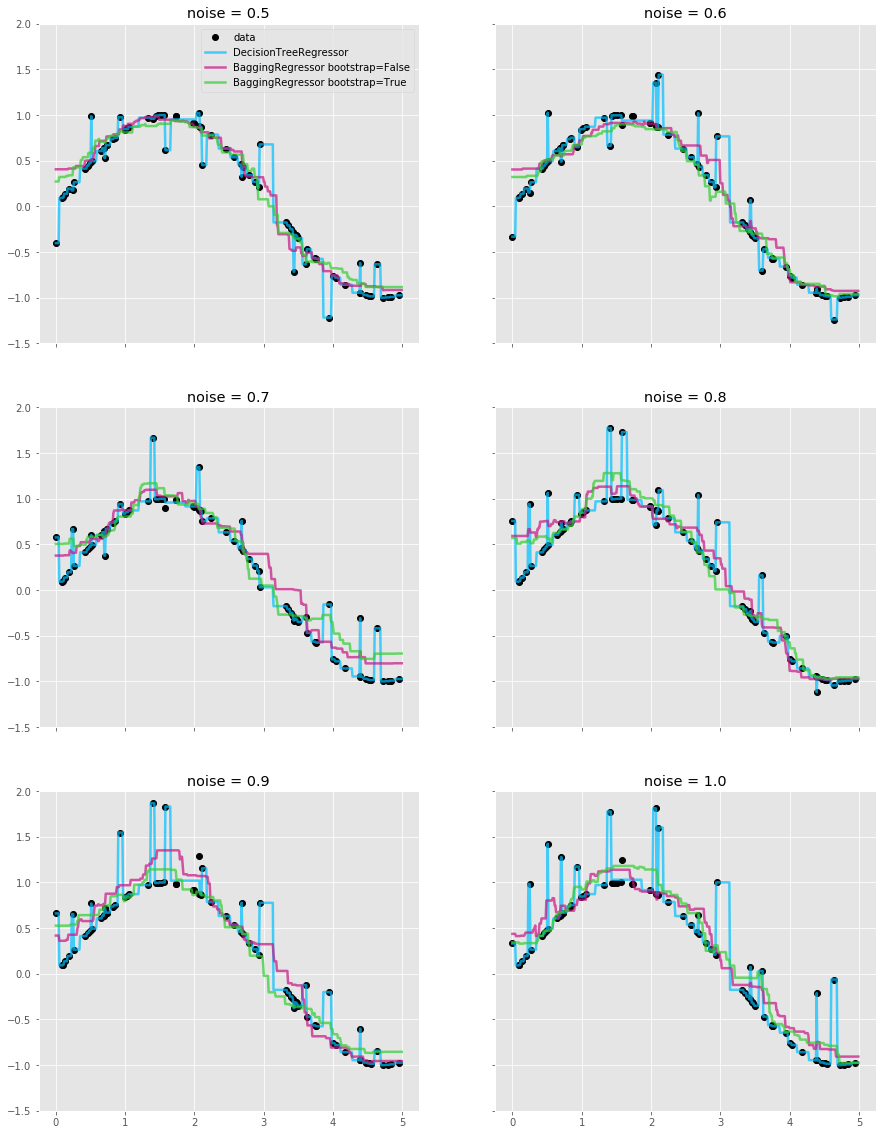

In [24]:
plot_noise_comparison(X, X_test, y_list, noise_list)

Les modèles d'arbres de décision et de bagging sont sensibles aux données bruitées, comme on peut l'observer pour différentes variations de bruit dans les données d'apprentissage. Il y a un sur-apprentissage.

# RANDOM FORESTS

# Question 6

In [25]:
# boston
boston = sklearn.datasets.load_boston()

# diabetes
diabetes = sklearn.datasets.load_diabetes()

# iris
iris = sklearn.datasets.load_iris()

# digits
digits = sklearn.datasets.load_digits()

In [26]:
data_r = [boston, diabetes]

scores_rf = []
scores_svm = []

print("REGRESSION")
for d in data_r:
    # X, y
    X_unscaled, y = d.data, d.target
    
    # Standardize
    X = preprocessing.scale(X_unscaled)
    
    # RF fitting
    model = RandomForestRegressor()
    scores = cross_val_score(model, X, y, cv=7)
    print("    | RandomForestRegression : ", scores)
    scores_rf.append(scores)
    
    # SVR fitting
    svr = SVR()
    scores_svr = cross_val_score(svr, X, y, cv=7)
    print("    | SVR : ", scores_svr)
    scores_svm.append(scores_svr)
    
    print("---")
    
data_cl = [iris, digits]
print("CLASSIFICATION")
for d in data_cl:
    # X, y
    X_unscaled, y = d.data, d.target
    
    # Standardize
    X = preprocessing.scale(X_unscaled)
    
    # RF fitting
    model = RandomForestClassifier()
    scores = cross_val_score(model, X, y, cv=7)
    print("    | RandomForestClassifier : ", scores)
    scores_rf.append(scores)
    
    # SVR fitting
    svc = SVC()
    scores_svc = cross_val_score(svc, X, y, cv=7)
    print("    | SVC : ", scores_svc)
    scores_svm.append(scores_svc)
    
    print("---")

REGRESSION
    | RandomForestRegression :  [ 0.71734197  0.78286063  0.79438028  0.65457135  0.61246307  0.3228188
  0.45142196]
    | SVR :  [ 0.7383728   0.79566612  0.2532935   0.08312684  0.68112495  0.13749193
  0.55458237]
---
    | RandomForestRegression :  [ 0.41891389  0.31018196  0.36109317  0.32772681  0.36740727  0.31473253
  0.38101985]
    | SVR :  [ 0.15422659  0.17243623  0.1689107   0.17409847  0.17415903 -0.00360633
  0.20774142]
---
CLASSIFICATION
    | RandomForestClassifier :  [ 0.95833333  1.          0.9047619   0.95238095  0.85714286  0.95238095
  1.        ]
    | SVC :  [ 0.95833333  1.          0.95238095  0.95238095  0.9047619   1.          1.        ]
---
    | RandomForestClassifier :  [ 0.91538462  0.92277992  0.83333333  0.92607004  0.9453125   0.93333333
  0.84126984]
    | SVC :  [ 0.95384615  0.97297297  0.90697674  0.96108949  0.9609375   0.97254902
  0.92857143]
---


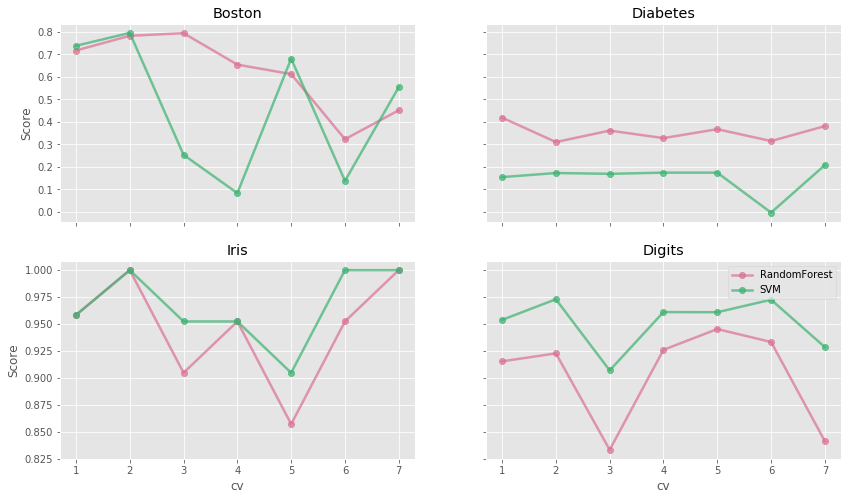

In [27]:
# row and column sharing
x = np.arange(1, 8, 1)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, scores_rf[0], marker="o", linewidth=lw, alpha=alp, 
         color=c_rf, label="RandomForest")
ax1.plot(x, scores_svm[0], marker="o", linewidth=lw, alpha=alp, 
         color=c_svm, label="SVM")
title1 = 'Boston'
ax1.set_title(title1)

ax2.plot(x, scores_rf[1], marker="o", linewidth=lw, alpha=alp, 
         color=c_rf, label="RandomForest")
ax2.plot(x, scores_svm[1], marker="o", linewidth=lw, alpha=alp, 
         color=c_svm, label="SVM")
title2 = title1 = 'Diabetes'
ax2.set_title(title2)

ax3.plot(x, scores_rf[2], marker="o", linewidth=lw, alpha=alp, 
         color=c_rf, label="RandomForest")
ax3.plot(x, scores_svm[2], marker="o", linewidth=lw, alpha=alp, 
         color=c_svm, label="SVM")
title3 = 'Iris'
ax3.set_title(title3)

ax4.plot(x, scores_rf[3], marker="o", linewidth=lw, alpha=alp, 
         color=c_rf, label="RandomForest")
ax4.plot(x, scores_svm[3], marker="o", linewidth=lw, alpha=alp, 
         color=c_svm, label="SVM")
title4 = 'Digits'
ax4.set_title(title4)

ax1.set_ylabel("Score")
ax3.set_ylabel("Score")

ax3.set_xlabel("cv")
ax4.set_xlabel("cv")

plt.axis("tight")
plt.legend()
plt.show()

De manière générale, les scores obtenus par 7-fold cross-validation sont meilleurs avec les SVM qu'avec RandomForest. 

# Question 7

In [28]:
# Parameters
n_estimators = 2
plot_colors = "bry"
plot_step = 0.02

def plot_proba(n_estimators=n_estimators):
    # Load data
    X_unscaled, y = iris.data[:, :2], iris.target

    # Standardize
    X = preprocessing.scale(X_unscaled)

    # RF fitting
    model = RandomForestClassifier(n_estimators=n_estimators)
    clf = model.fit(X, y)

    # Plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

    plt.figure()
    for tree in model.estimators_:
        # use predict to obtain the probabilities you will store in Z
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=1. / n_estimators, cmap=plt.cm.Paired)
    plt.axis("tight")

    # Plot the training points
    for i, c in zip(range(3), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                cmap=plt.cm.Paired)
    plt.legend(scatterpoints=1)
    title = "Prediction probability for n_estimators = %d" %n_estimators
    plt.title(title)
    plt.show()                     

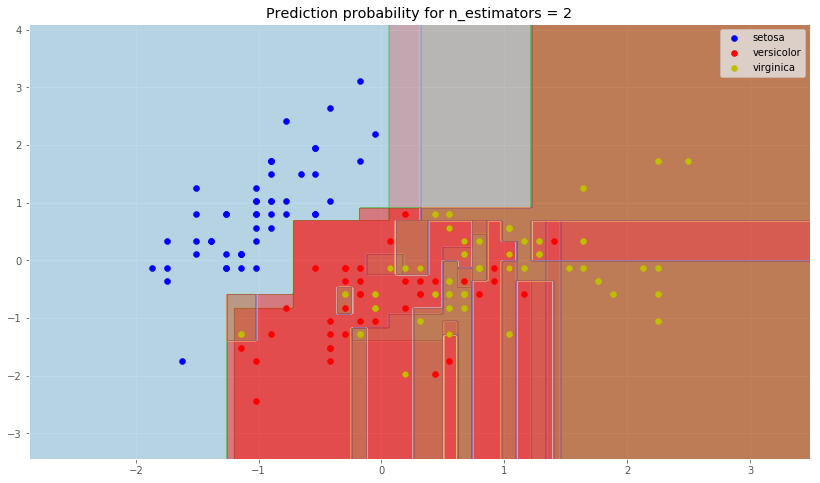

In [29]:
plot_proba()

In [30]:
def plot_proba_range(range_estimators):
    # 2 columns
    if (len(range_estimators) % 2 == 0):
        print("Number of plots : even")
        n_rows = int(len(range_estimators) / 2)
    else: 
        print("Number of plots : odd")
        n_rows = int(len(range_estimators) / 2) + 1
    print("Number of rows :", n_rows)
    
    fig, axs = plt.subplots(n_rows, 2, facecolor='w', edgecolor='k', figsize=(25,20))
    #fig.subplots_adjust(hspace = .5, wspace=.001)

    # Load data
    X_unscaled, y = iris.data[:, :2], iris.target

    # Standardize
    X = preprocessing.scale(X_unscaled)

    for k in range(n_rows):
        print("Line ", k)
        j = 0
        for l in range_estimators[2*k:2*(k+1)]:
            print("        | Estimator ", l)
            # RF fitting
            model = RandomForestClassifier(n_estimators=l)
            clf = model.fit(X, y)

            # Plot the decision boundary
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

            #plt.figure()
            for tree in model.estimators_:
                # use predict to obtain the probabilities you will store in Z
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = axs[k][j].contourf(xx, yy, Z, alpha=1. / l, cmap=plt.cm.Paired)
            plt.axis("tight")

            # Plot the training points
            for i, c in zip(range(3), plot_colors):
                idx = np.where(y == i)
                axs[k][j].scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=plt.cm.Paired)
            axs[k][j].legend(scatterpoints=1)
            
            title = "Prediction probability for n_estimators = %d" %l
            axs[k][j].set_title(title)
                
            j += 1
    plt.show()                     

Number of plots : even
Number of rows : 4
Line  0
        | Estimator  5
        | Estimator  10
Line  1
        | Estimator  15
        | Estimator  20
Line  2
        | Estimator  30
        | Estimator  50
Line  3
        | Estimator  80
        | Estimator  100


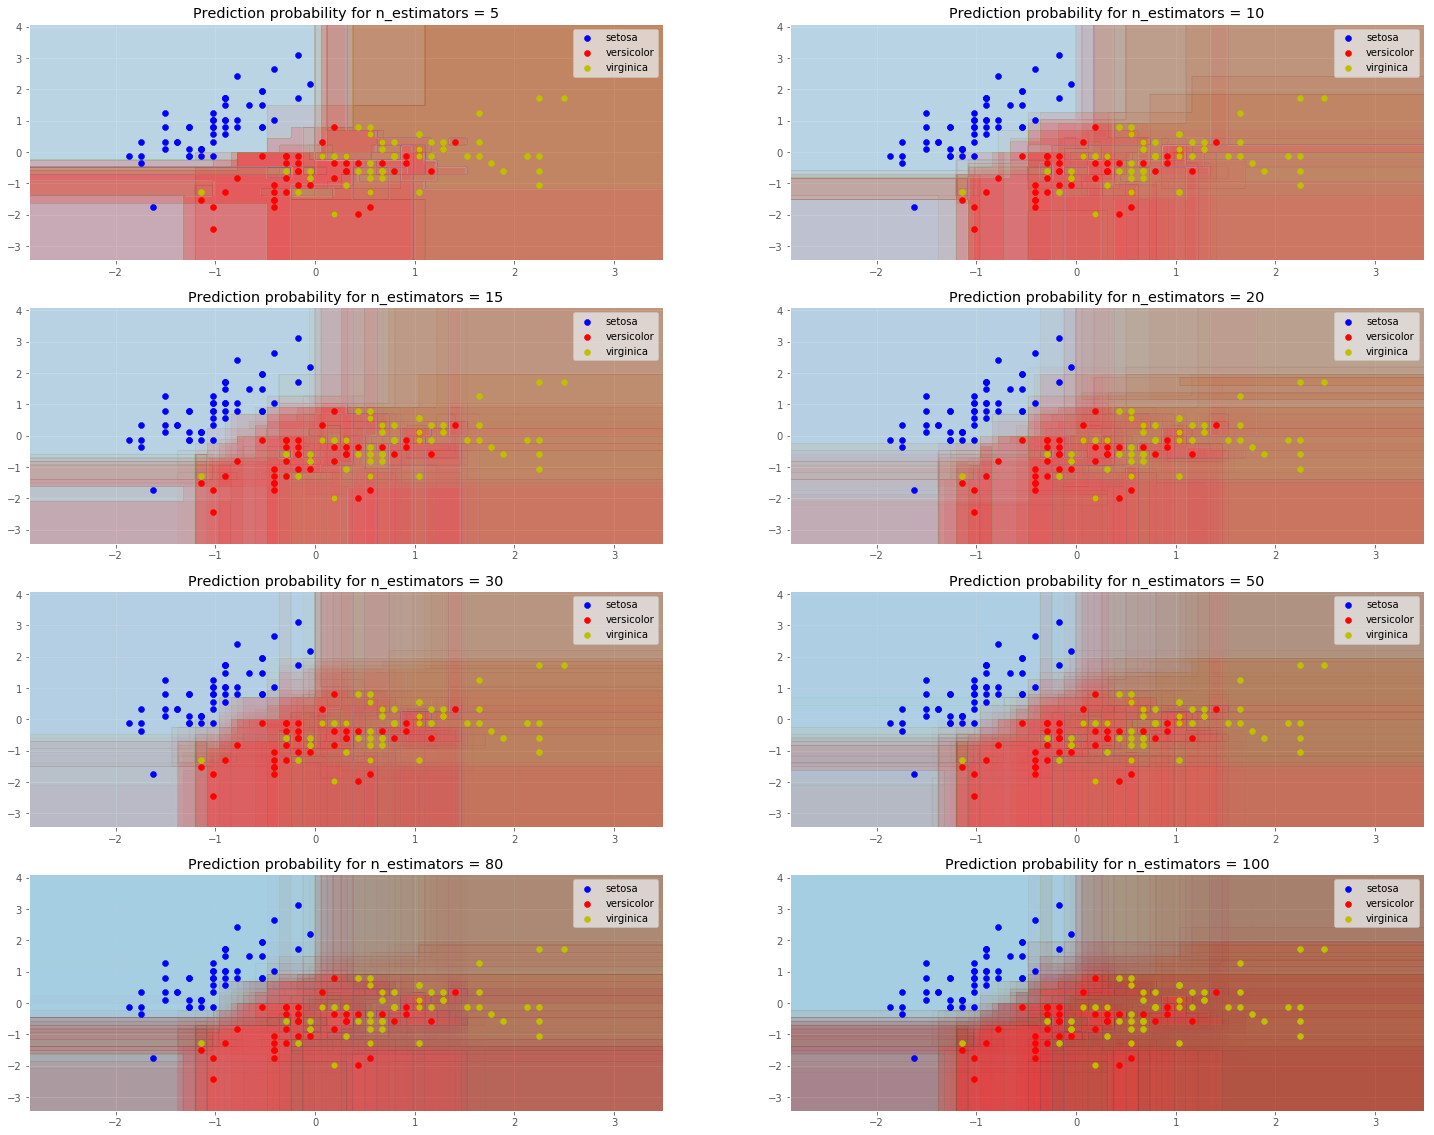

In [31]:
plot_proba_range([5, 10, 15, 20, 30, 50, 80, 100])

Pour un nombre d'arbres aléatoires de plus en plus élevé, on remarque que les données sont classifiées de plus en plus précisément. Le modèle est davantage complexe. 

# Question 8

In [32]:
# Load and Shuffle data
X_unscaled, y = sh(iris.data[:, :2], iris.target, random_state=0)

# Standardize
X = preprocessing.scale(X_unscaled)

    
def compare_rf_dt(X, y, max_depth=1):
    # RF fitting
    rf = RandomForestClassifier(max_depth=max_depth)
    scores_rf = cross_val_score(rf, X, y, cv=6)
    #print("RandomForestClassifier : ", scores_rf)

    # DT fitting
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores_dt = cross_val_score(dt, X, y, cv=6)
    #print("DecisionTreeClassifier : ", scores_dt)
    
    return scores_rf, scores_dt

In [33]:
s = np.arange(1, 31, 1)

means_rf = np.zeros(len(s))
means_dt = np.zeros(len(s))

std_rf = np.zeros(len(s))
std_dt = np.zeros(len(s))

for d in s:
    scores_rf, scores_dt = compare_rf_dt(X, y, max_depth=d)
    means_rf[d - 1] = scores_rf.mean()
    means_dt[d - 1] = scores_dt.mean()
    
    std_rf[d - 1] = scores_rf.std()
    std_dt[d - 1] = scores_dt.std()

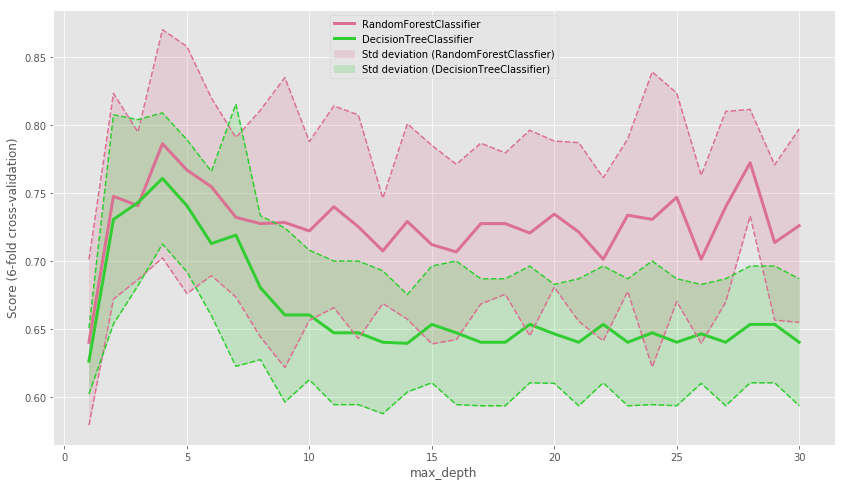

In [34]:
# Plot results   
plt.plot(s, means_rf, linewidth=3, color=c_rf, label="RandomForestClassifier")
plt.plot(s, means_dt, linewidth=3, color=c_dt, label="DecisionTreeClassifier")

plt.plot(s, means_rf + std_rf, linestyle="--", color=c_rf)
plt.plot(s, means_rf - std_rf, linestyle="--", color=c_rf)
plt.fill_between(s, means_rf - std_rf, means_rf + std_rf, color=c_rf, alpha=0.2, label="Std deviation (RandomForestClassfier)")

plt.plot(s, means_dt + std_dt, linestyle="--", color=c_dt)
plt.plot(s, means_dt - std_dt, linestyle="--", color=c_dt)
plt.fill_between(s, means_dt - std_dt, means_dt + std_dt, color=c_dt, alpha=0.2, label="Std deviation (DecisionTreeClassifier)")

plt.ylabel("Score (6-fold cross-validation)")
plt.xlabel("max_depth")
plt.legend()
plt.show()

Les scores sont globalement plus élevés avec les forêts aléatoires qu'avec les arbres de décision. On avait vu dans les questions précédentes que l'arbre de décision a tendance à sur-apprendre pour des valeurs de profondeurs supérieures à  15, ce qui n'est pas le cas pour les forêts aléatoires.

# BOOSTING

# Question 9

À patir des propriétés de l'espérance conditionnelle, décomposons l'expression $\mathbb{E}[e^{-Yf(x)}]$ de la manière suivante :

$\mathbb{E}[e^{-Yf(x)}] = P(Y=-1|x)e^{+f(x)} + P(Y=-1|x)e^{-f(x)}$ 

$\mathbb{E}[e^{-Yf(x)}] = (1 - \eta (x))e^{+f(x)} + \eta (x) e^{-f(x)}$

On dérive l'expression par rapport à $f(x)$.

$\frac{\partial \mathbb{E}[exp(-Yf(x))]}{\partial f(x)} = (1 - \eta (x))e^{+f(x)} - \eta (x) e^{-f(x)}$

en particulier, en $f^*(x)$ : $(1 - \eta (x))e^{+f^*(x)} - \eta (x) e^{-f^*(x)} = 0$

$(1 - \eta (x)) e^{2f^*(x)} - \eta (x) = 0$

Finalement, $f^*(x) = \dfrac{1}{2}log(\dfrac{\eta (x)}{1 - \eta (x)})$

# Question 10

On a : $h^*_{\phi_0} = sign(2\eta - 1)$

En utilisant le résultat obtenu lors de la question précédente, on a :
$h^*_{exp} = sign(f_{exp})$, où $f_{exp}(x) = \dfrac{1}{2}log(\dfrac{\eta (x)}{1 - \eta (x)})$

$h^*_{exp} = sign(\dfrac{1}{2}log(\dfrac{\eta (x)}{1 - \eta (x)})) = sign(log(\dfrac{\eta (x)}{1 - \eta (x)})) $

Or 

$$
log(\dfrac{\eta (x)}{1 - \eta (x)}) \left\{
    \begin{array}{ll}
        \geq 0 & \mbox{si } \eta (x) \geq 1 - \eta (x) \\
        < 0 & \mbox{sinon.}
    \end{array}
\right.
$$

Donc

$$
log(\dfrac{\eta (x)}{1 - \eta (x)}) \left\{
    \begin{array}{ll}
        \geq 0 & \mbox{si } 2\eta (x) \geq 1 \\
        < 0 & \mbox{sinon.}
    \end{array}
\right.
$$

D'où $h^*_{exp} = sign(2\eta - 1) = h^*_{\phi_0}$

# Question 11

En utilisant un raisonnement analogue à la question 9, on obtient : 

$\mathbb{E}_{\omega^{m-1}}[e^{-cY\hat{h}_{m}(x)}] = P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{-c} + P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{c}$ 

On dérive par rapport à $c$ : 
$\frac{\partial \mathbb{E}_{\omega^{m-1}}[e^{-cY\hat{h}_{m}(x)}]}{\partial c} = -P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{-c} + P_{\omega^{m-1}}(Y\neq \hat{h}_{m}(x))e^{c}$

En particulier, en $c^*$ : 

$-P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{-c^*} + P_{\omega^{m-1}}(Y\neq\hat{h}_{m}(x))e^{c^*} = 0$

D'où le résultat : $c^* = \dfrac{1}{2}log(\dfrac{P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))}{P_{\omega^{m-1}}(Y\neq\hat{h}_{m}(x))})$

# Question 12

# Question 13

In [35]:
# X, y
X_digits_unscaled, y_digits = digits.data, digits.target

# Standardize
X_digits = preprocessing.scale(X_digits_unscaled)
    
depths = np.arange(1, 11, 1) 
def set_max_depth_adaboost(X, y, max_depth=depths, L=10, cv=6):
    means_scores = np.zeros(len(max_depth))
    std_scores = np.zeros(len(max_depth))

    for i, depth in enumerate(max_depth, 0):
        print("Depth = ", depth)
        tree = DecisionTreeClassifier(max_depth=depth)
        adaboost = AdaBoostClassifier(base_estimator=tree, n_estimators=L, algorithm="SAMME")
        scores = cross_val_score(adaboost, X, y, cv=cv)
        means_scores[i] = scores.mean()
        std_scores[i] = scores.std()

    return means_scores, std_scores

In [36]:
means_adaboost, std_adaboost = set_max_depth_adaboost(X_digits, y_digits)

Depth =  1
Depth =  2
Depth =  3
Depth =  4
Depth =  5
Depth =  6
Depth =  7
Depth =  8
Depth =  9
Depth =  10


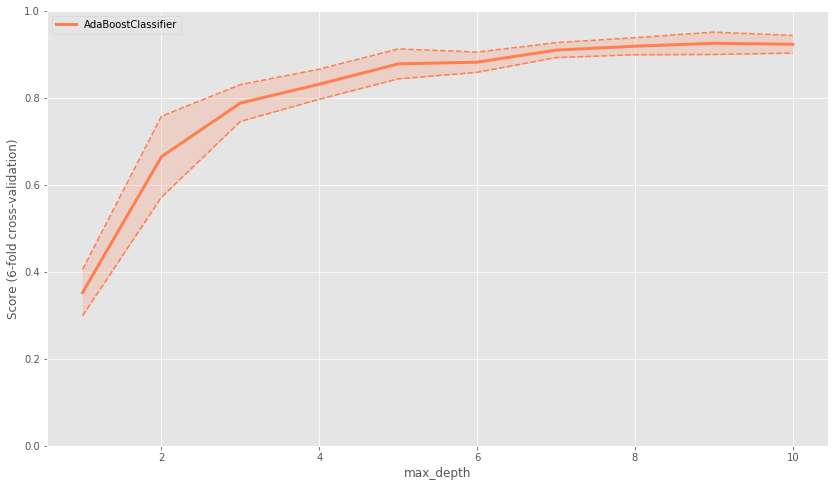

In [37]:
c_adaboost = "coral"

# Plot results   
plt.plot(depths, means_adaboost, linewidth=3, color=c_adaboost, label="AdaBoostClassifier")

plt.plot(depths, means_adaboost + std_adaboost, linestyle="--", color=c_adaboost)
plt.plot(depths, means_adaboost - std_adaboost, linestyle="--", color=c_adaboost)
plt.fill_between(depths, means_adaboost - std_adaboost, means_adaboost + std_adaboost, color=c_adaboost, alpha=0.2)

plt.ylim(0, 1)
plt.ylabel("Score (6-fold cross-validation)")
plt.xlabel("max_depth")
plt.legend()
plt.show()

Le score par 6-fold cross-validation augmente de manière significative selon la profondeur de l'arbre. A partir d'une profondeur de 6 le score se stabilise, comme en témoignent les valeurs proches de 0.9 et l'écart type faible pour des valeurs de 6 à 10.

# Question 14

In [38]:
X_digits_train, X_digits_test, y_digits_train, y_digits_test = train_test_split(digits.data, digits.target, 
                                                                                test_size=0.25, random_state=42)

n_iter = np.arange(5, 50)

In [39]:
def compare_adaboost_tree(X_digits_train=X_digits_train, X_digits_test=X_digits_test, 
                          y_digits_train=y_digits_train, y_digits_test=y_digits_test, 
                          n_iter=n_iter, depth=10):    
    loss_train_tree = np.zeros(len(n_iter))
    loss_test_tree = np.zeros(len(n_iter))

    loss_train = np.zeros(len(n_iter))
    loss_test = np.zeros(len(n_iter))

    for i, itr in enumerate(n_iter, 0):
        tree = RandomForestClassifier(max_depth=depth, n_estimators=itr)
        tree.fit(X_digits_train, y_digits_train)
        y_pred_train_tree = tree.predict(X_digits_train)
        y_pred_test_tree = tree.predict(X_digits_test)

        loss_train_tree[i] = zero_one_loss(y_digits_train, y_pred_train_tree)
        loss_test_tree[i] = zero_one_loss(y_digits_test, y_pred_test_tree)

        adaboost = AdaBoostClassifier(base_estimator=tree, n_estimators=itr, algorithm="SAMME")
        adaboost.fit(X_digits_train, y_digits_train)
        y_pred_train = adaboost.predict(X_digits_train)
        y_pred_test = adaboost.predict(X_digits_test)

        loss_train[i] = zero_one_loss(y_digits_train, y_pred_train)
        loss_test[i] = zero_one_loss(y_digits_test, y_pred_test)
        
    return loss_train_tree, loss_test_tree, loss_train, loss_test

In [40]:
loss_train_tree, loss_test_tree, loss_train, loss_test = compare_adaboost_tree()

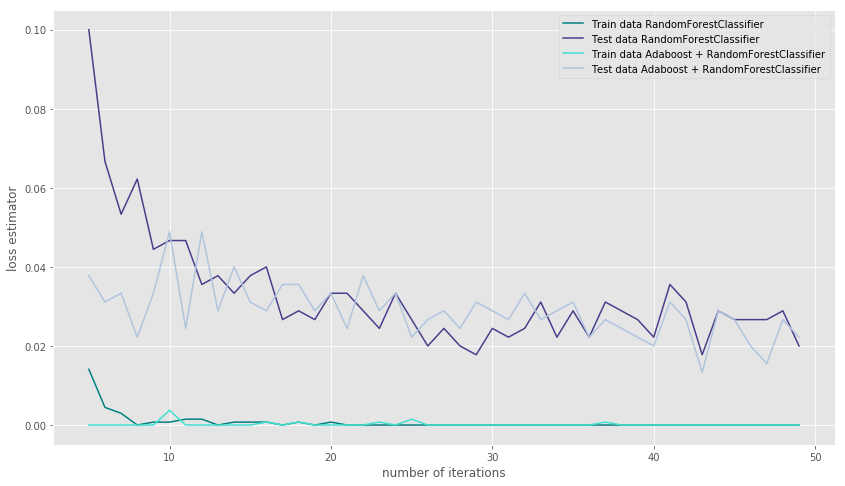

In [41]:
plt.plot(n_iter, loss_train_tree, color=c_train, label="Train data RandomForestClassifier")
plt.plot(n_iter, loss_test_tree, color=c_test, label="Test data RandomForestClassifier")

plt.plot(n_iter, loss_train, color=c_train_adaboost, label="Train data Adaboost + RandomForestClassifier")
plt.plot(n_iter, loss_test, color=c_test_adaboost, label="Test data Adaboost + RandomForestClassifier")

plt.xlabel("number of iterations")
plt.ylabel("loss estimator")
plt.legend()
plt.show()

# Question 15

In [42]:
loss_train_tree_depth = np.zeros(len(n_iter))
loss_test_tree_depth = np.zeros(len(n_iter))

loss_train_depth = np.zeros(len(n_iter))
loss_test_depth = np.zeros(len(n_iter))

for i, itr in enumerate(n_iter, 0):
    tree = RandomForestClassifier(max_depth=100, n_estimators=itr)
    tree.fit(X_digits_train, y_digits_train)
    y_pred_train_tree = tree.predict(X_digits_train)
    y_pred_test_tree = tree.predict(X_digits_test)
    
    loss_train_tree_depth[i] = zero_one_loss(y_digits_train, y_pred_train_tree)
    loss_test_tree_depth[i] = zero_one_loss(y_digits_test, y_pred_test_tree)
    
    adaboost = AdaBoostClassifier(base_estimator=tree, n_estimators=itr, algorithm="SAMME")
    adaboost.fit(X_digits_train, y_digits_train)
    y_pred_train = adaboost.predict(X_digits_train)
    y_pred_test = adaboost.predict(X_digits_test)
    
    loss_train_depth[i] = zero_one_loss(y_digits_train, y_pred_train)
    loss_test_depth[i] = zero_one_loss(y_digits_test, y_pred_test)

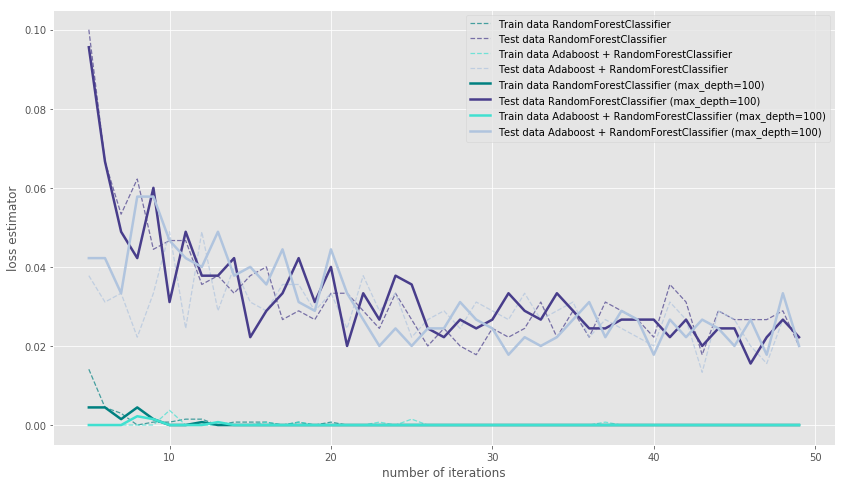

In [43]:
plt.plot(n_iter, loss_train_tree, linestyle="--", linewidth=lw/2, alpha=alp, color=c_train, label="Train data RandomForestClassifier")
plt.plot(n_iter, loss_test_tree, linestyle="--", linewidth=lw/2, alpha=alp, color=c_test, label="Test data RandomForestClassifier")

plt.plot(n_iter, loss_train, linestyle="--", linewidth=lw/2, alpha=alp, color=c_train_adaboost, label="Train data Adaboost + RandomForestClassifier")
plt.plot(n_iter, loss_test, linestyle="--", linewidth=lw/2, alpha=alp, color=c_test_adaboost, label="Test data Adaboost + RandomForestClassifier")

plt.plot(n_iter, loss_train_tree_depth, linewidth=lw, color=c_train, label="Train data RandomForestClassifier (max_depth=100)")
plt.plot(n_iter, loss_test_tree_depth, linewidth=lw, color=c_test, label="Test data RandomForestClassifier (max_depth=100)")

plt.plot(n_iter, loss_train_depth, linewidth=lw, color=c_train_adaboost, label="Train data Adaboost + RandomForestClassifier (max_depth=100)")
plt.plot(n_iter, loss_test_depth, linewidth=lw, color=c_test_adaboost, label="Test data Adaboost + RandomForestClassifier (max_depth=100)")


plt.xlabel("number of iterations")
plt.ylabel("loss estimator")
plt.legend()
plt.show()

In [44]:
# Generate new lines with different depths

depth_sample = np.arange(10, 150, 5)

loss_train_tree_all = np.zeros((len(depth_sample), len(n_iter)))
loss_test_tree_all = np.zeros((len(depth_sample), len(n_iter)))
loss_train_all = np.zeros((len(depth_sample), len(n_iter)))
loss_test_all = np.zeros((len(depth_sample), len(n_iter)))

for i, d in enumerate(depth_sample, 0): 
    print("Depth = ", d)
    l_train_tree, l_test_tree, l_train, l_test = compare_adaboost_tree(depth=d)
    
    loss_train_tree_all[i, : ] = l_train_tree
    loss_test_tree_all[i, : ] = l_test_tree
    loss_train_all[i, : ] = l_train
    loss_test_all[i, : ] = l_test

Depth =  10
Depth =  15
Depth =  20
Depth =  25
Depth =  30
Depth =  35
Depth =  40
Depth =  45
Depth =  50
Depth =  55
Depth =  60
Depth =  65
Depth =  70
Depth =  75
Depth =  80
Depth =  85
Depth =  90
Depth =  95
Depth =  100
Depth =  105
Depth =  110
Depth =  115
Depth =  120
Depth =  125
Depth =  130
Depth =  135
Depth =  140
Depth =  145


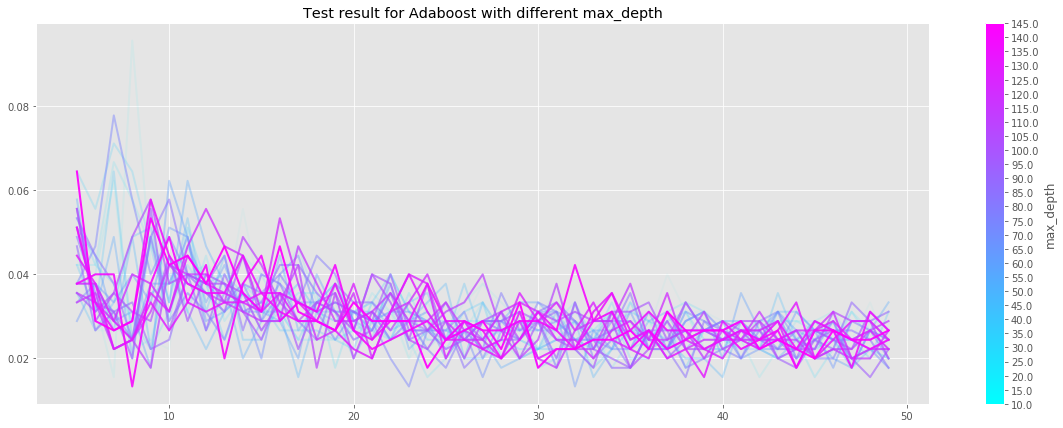

In [45]:
# Use the spectral colormap for examples
cmap = plt.cm.cool

nlines = loss_test_all.shape[0]

# Use 0-1 values to generate the colors with the linspace method
line_colors = cmap(np.linspace(0,1,nlines))

# We have to generate our own axis to put the colorbar in
# otherwise it "steals" space from the current axis.  Please
# let me know if anyone has found another way around this,
# because the custom axes generation is the only way I've
# figured out.
fig, ax = plt.subplots(figsize=(20,7))

# Plot with colorbar
ax.set_title('Test result for Adaboost with different max_depth')

for i in range(nlines):
    ax.plot(n_iter, loss_test_all[i, :], c=line_colors[i], alpha=(i+1)/30, lw=2,label='{:3.1f}'.format(depth_sample[i]))
    
# Generate fake ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=depth_sample[0],vmax=depth_sample[-1]))
sm.set_array([])  # You have to set a dummy-array for this to work...
cbar = plt.colorbar(sm)
cbar.set_label('max_depth')
cbar.set_ticks(depth_sample)
cbar.set_ticklabels(['{:4.1f}'.format(yi) for yi in depth_sample]) # Make 'em nicer-looking

plt.show() 

À partir d'une certaine profondeur d'arbres, le score d'AdaBoost sur les données tests ne s'améliore plus.

Une façon de résoudre le compromis biais/variance consiste donc à utiliser des modèles tels que le boosting, qui combine plusieurs "mauvais" modèles (biais élevé) dans un ensemble qui a un biais plus faible que les modèles individuels, ainsi que le bagging qui combine les "meilleurs" classifieurs d'une manière qui réduit leur variance.